In [ ]:
!pip install z3-solver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 45.3 MB/s eta 0:00:00


In [ ]:
import random
from itertools import combinations
from z3 import *
import time
from copy import deepcopy


def G(n, p):
    matrix = [[1 if (random.uniform(0, 1) <= p) else 0 for j in range(n)] for i in range(n)]
    e = sum([sum(v) for v in matrix])

    for i in range(n):
        for j in range(i + 1, n):
            matrix[j][i] = matrix[i][j]
    return matrix, e


def dfs(Node, matrix, visited, n, deg=None):
    visited[Node] = True
    for i in range(n):
        if matrix[Node][i] == 1:
            if deg:
                deg[Node] += 1 if Node != i else 2
            if not visited[i]:
                dfs(i, matrix, visited, n, deg)

def cal_degs(n, matrix):
    visited = [False] * n
    result = [0] * n
    for node in range(n):
        if not visited[node]:
            dfs(node, matrix, visited, n, result)
    return result



def cover_estimation(matrix):
    degs = cal_degs(len(matrix), matrix)
    vc = 0

    while sum(degs) != 0:
        index_max = degs.index(max(degs))
        degs[index_max] = 0

        for i in range(len(matrix)):
            if matrix[index_max][i] == 1 and not i == index_max:
                degs[i] -= 1
            matrix[i][index_max] = 0

        for i in range(len(matrix)):
            matrix[index_max][i] = 0

        vc += 1
    return vc


def brute(matrix, k):
    n = len(matrix)
    vertexes = [i for i in range(n)]

    def generate_k_subsets(k):
        for subset in combinations(vertexes, k):
            yield subset

    def if_cover(subset):
        for i in range(n):
            for j in range(i, n):
                if matrix[i][j] == 1 and i not in subset and j not in subset:
                    return False
        return True

    for subset in generate_k_subsets(k):
        if if_cover(set(subset)):
            return True
    return False


def smt_solver(matrix, k):
    n = len(matrix)
    solver = z3.Solver()

    vertexes = [z3.Bool(v) for v in range(n)]

    for i in range(n):
        for j in range(i, n):
            if matrix[i][j]:
                solver.add(z3.Or(vertexes[i], vertexes[j]))

    solver.add(Sum([If(v, 1, 0) for v in vertexes]) <= k)
    return solver.check() == z3.sat


def times(algorithm, matrix, k):
    start = time.time()
    algorithm(matrix, k)
    end = time.time()
    return end - start


def gen_data(alg1, alg2, matrix, k):
    t1 = times(alg1, matrix, k)
    t2 = times(alg2, matrix, k)
    return {
        "t1": t1,
        "t2": t2,
        "n": len(matrix),
        "k": k
    }


def test_generator(nr):
    p = 0.1
    i = 0

    def gen():
        nonlocal i, p
        while p < 1:
            n = random.randint(3, 30)
            if i > nr:
                i = 0
                p += 0.05
            A, e = G(n, p)
            B = deepcopy(A)
            estimation = cover_estimation(B)
            if estimation != 0:
              estimation -= random.randint(0, 1)
            yield (A, estimation, e,)
            i += 1

    return gen


data = []
iter = 0
generator = test_generator(30)
for A, estimation, e in generator():
    print(f"iter: {iter} estimation: {estimation}  e: {e}  n: {len(A)}")
    iter += 1
    dic = gen_data(smt_solver, brute, A, estimation)
    dic["e"] = e
    data.append(dic)

iter: 0 estimation: 3  e: 21  n: 14
iter: 1 estimation: 9  e: 55  n: 22
iter: 2 estimation: 16  e: 90  n: 28
iter: 3 estimation: 0  e: 3  n: 8
iter: 4 estimation: 15  e: 77  n: 25
iter: 5 estimation: 9  e: 52  n: 22
iter: 6 estimation: 10  e: 72  n: 27
iter: 7 estimation: 5  e: 26  n: 17
iter: 8 estimation: 5  e: 24  n: 17
iter: 9 estimation: 3  e: 7  n: 9
iter: 10 estimation: 10  e: 47  n: 21
iter: 11 estimation: 9  e: 42  n: 21
iter: 12 estimation: 1  e: 3  n: 3
iter: 13 estimation: 2  e: 4  n: 4
iter: 14 estimation: 3  e: 13  n: 10
iter: 15 estimation: 15  e: 89  n: 30
iter: 16 estimation: 13  e: 88  n: 29
iter: 17 estimation: 1  e: 4  n: 5
iter: 18 estimation: 3  e: 10  n: 10
iter: 19 estimation: 1  e: 5  n: 7
iter: 20 estimation: 1  e: 5  n: 11
iter: 21 estimation: 2  e: 18  n: 15
iter: 22 estimation: 12  e: 53  n: 23
iter: 23 estimation: 9  e: 48  n: 22
iter: 24 estimation: 8  e: 38  n: 24
iter: 25 estimation: 9  e: 26  n: 16
iter: 26 estimation: 5  e: 24  n: 15
iter: 27 estimati

<ipython-input-60-1b2f3aae59c1>:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


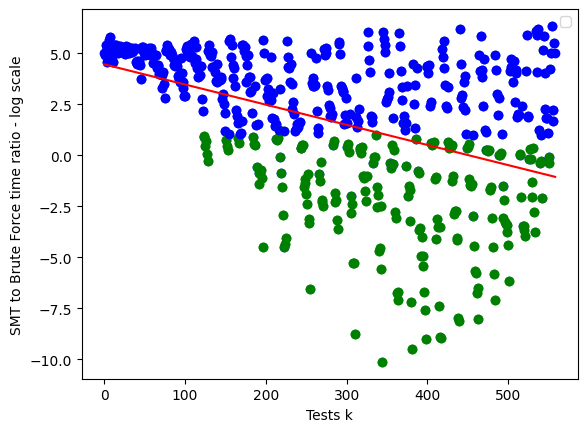

<ipython-input-60-1b2f3aae59c1>:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


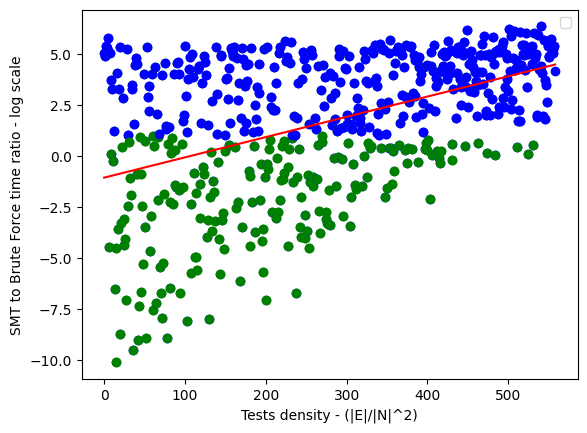

<ipython-input-60-1b2f3aae59c1>:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


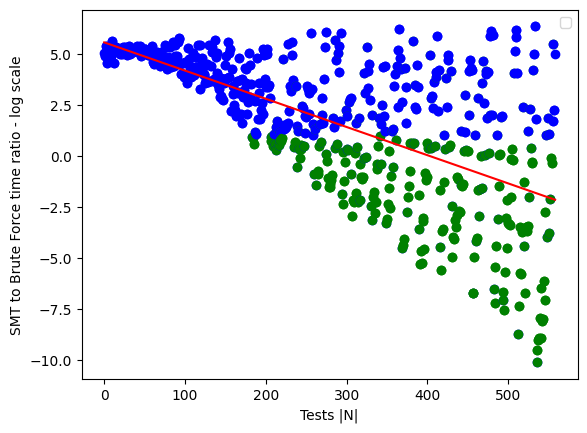

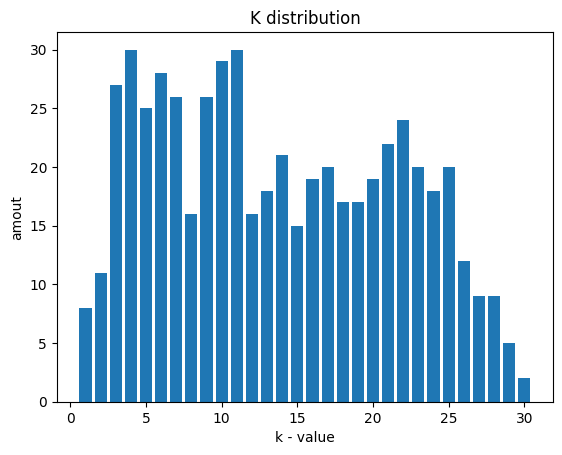

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import math

def plot_data(x, y, order = ""):
  y = [math.log(x) for x in y]
  x = np.array(range(len(y))).reshape(-1, 1)
  model = LinearRegression()
  model.fit(x, y)

  for i in range(len(x) - 1):
      if y[i] >= 1:
          plt.scatter(x[i:i+2], y[i:i+2], color="blue")
      else:
          plt.scatter(x[i:i+2], y[i:i+2], color="green")
  plt.plot(x, model.predict(x), color = "red")

  plt.ylabel("SMT to Brute Force time ratio - log scale")
  plt.xlabel("Tests " + order)

  plt.legend()
  plt.show()


def k_distribution(data):
  k_to_nr = [0] * 30
  for test in data:
    k_to_nr[test["k"]] += 1

  plt.bar([x for x in range(1, 31)], k_to_nr)
  plt.title('K distribution')
  plt.xlabel('k - value')
  plt.ylabel('amout')
  plt.show()

def process_data(data):
  def time_diff(data):
    return [v["t1"] / v["t2"] for v in data]

  data.sort(key=lambda x: x["k"])
  plot_data([i["k"] for i in data],time_diff(data), order ="k" )

  data.sort(key=lambda x: x["e"] / (x["n"] * x["n"]))
  plot_data([x["e"] / (x["n"] * x["n"]) for x in data], time_diff(data), order = "density - (|E|/|N|^2)")

  data.sort(key=lambda x: x["n"])
  plot_data([i["n"] for i in data], time_diff(data), order = "|N|")

process_data(data)
k_distribution(data)

In [2]:
import statistics

def time_test(alg):
  p = [i/100 for i in range(10, 91, 20)]
  times_for_n = [0]
  k_values = []
  prev_k_values = []
  n = 30
  while statistics.mean(times_for_n) < 120:
    print(f"n: {n}")
    times_for_n = []
    prev_k_vales = k_values
    k_values = []
    for pi in p:
      A, e = G(n, pi)
      B = deepcopy(A)
      estimation = cover_estimation(B)
      time = times(alg, A, estimation)
      if estimation != 0:
        estimation -= random.randint(0, 1)
      times_for_n.append(time)
      k_values.append(estimation)
    print(times_for_n)
    n += 1

  return n, prev_k_vales

n_brute, k_brute = time_test(brute)
n_smt, k_smt = time_test(smt_solver)

NameError: name 'brute' is not defined

NameError: name 'n_brute' is not defined